In [1]:
%pip install scipy matplotlib numpy torch torchvision

Note: you may need to restart the kernel to use updated packages.


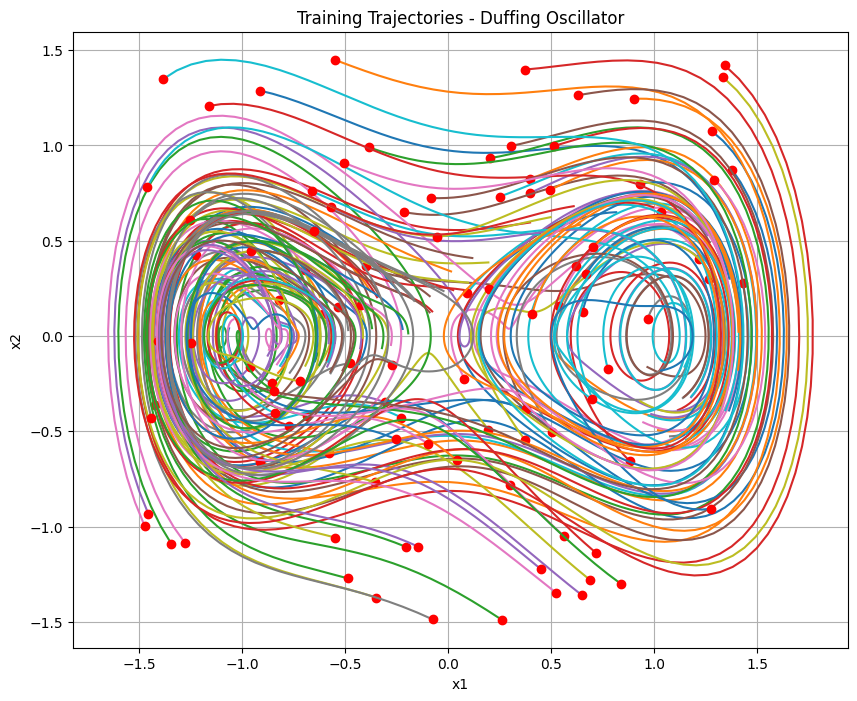

Training neural network...
Epoch [50/1000], Loss: 0.00077854
Epoch [100/1000], Loss: 0.00013171
Epoch [150/1000], Loss: 0.00005470
Epoch [200/1000], Loss: 0.00002982
Epoch [250/1000], Loss: 0.00002031
Epoch [300/1000], Loss: 0.00001612
Epoch [350/1000], Loss: 0.00001278
Epoch [400/1000], Loss: 0.00001217
Epoch [450/1000], Loss: 0.00001027
Epoch [500/1000], Loss: 0.00000919
Epoch [550/1000], Loss: 0.00000913
Epoch [600/1000], Loss: 0.00000950
Epoch [650/1000], Loss: 0.00000999
Epoch [700/1000], Loss: 0.00000775
Epoch [750/1000], Loss: 0.00000721
Epoch [800/1000], Loss: 0.00000889
Epoch [850/1000], Loss: 0.00000930
Epoch [900/1000], Loss: 0.00000684
Epoch [950/1000], Loss: 0.00000616
Epoch [1000/1000], Loss: 0.00000755
Training completed!


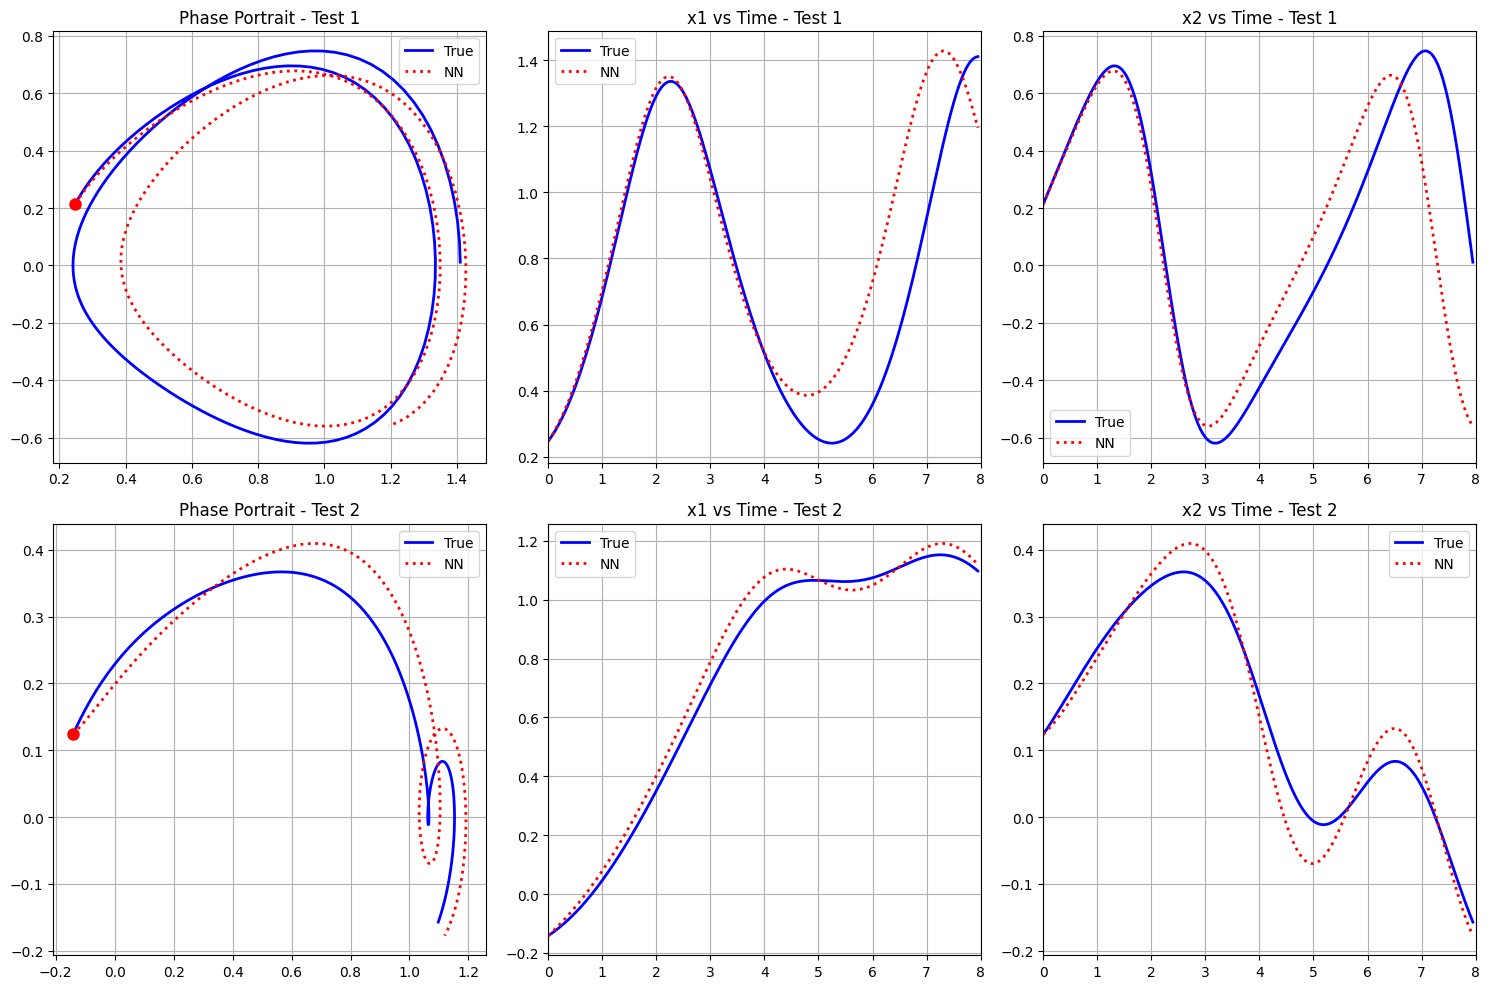


Error Metrics:
Mean Squared Error: 0.2836%
Mean Absolute Error: 4.0621%


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from torch.utils.data import TensorDataset, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
dt = 0.05
T = 8
t = np.arange(0, T, dt)
b = 0.3
sig = 10
r = 28
a = 0.35
w = 1

# Duffing oscillator function
def duffing_system(state, t):
    x1, x2 = state
    dx1_dt = x2
    dx2_dt = x1 - x1**3 - a*x2 + b*np.cos(w*t)
    return [dx1_dt, dx2_dt]

# Generate training data
input_data = []
output_data = []

plt.figure(1, figsize=(10, 8))
plt.clf()

for j in range(100):  # training trajectories - reduced from 100
    # Generate 2D initial conditions
    x0 = 3 * (np.random.rand(2) - 0.5)
    
    # Solve ODE
    sol = odeint(duffing_system, x0, t)
    
    # Prepare input-output pairs: add cos(w*t) as third input feature
    inputs = np.hstack([sol[:-1, :], np.cos(w * t[:-1]).reshape(-1, 1)])  # [x1, x2, cos(wt)]
    targets = sol[1:, :]  # x(t+1)
    
    input_data.append(inputs)
    output_data.append(targets)
    
    # Plot trajectory
    plt.plot(sol[:, 0], sol[:, 1])
    plt.plot(x0[0], x0[1], 'ro')

plt.grid(True)
plt.title('Training Trajectories - Duffing Oscillator')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Concatenate all training data
input_array = np.vstack(input_data)
output_array = np.vstack(output_data)

# Normalize inputs/outputs (important)
X_mean = input_array.mean(axis=0)
X_std = input_array.std(axis=0) + 1e-8
y_mean = output_array.mean(axis=0)
y_std = output_array.std(axis=0) + 1e-8

input_norm = (input_array - X_mean) / X_std
output_norm = (output_array - y_mean) / y_std

# Convert to PyTorch tensors and DataLoader
X_train = torch.FloatTensor(input_norm).to(device)
y_train = torch.FloatTensor(output_norm).to(device)

batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define Neural Network (input size 3 now)
class DuffingNet(nn.Module):
    def __init__(self):
        super(DuffingNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(3, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 2)
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize network
net = DuffingNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
# Optionally: scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

# Training (mini-batch)
print("Training neural network...")
epochs = 1000
best_loss = float('inf')
patience = 20
patience_counter = 0

for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = net(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)

    if (epoch + 1) % 50 == 0:  # Print every 50 epochs instead of 100
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.8f}')

print("Training completed!")

# Test the network
def predict_trajectory(net, x0, t, X_mean, X_std, y_mean, y_std):
    """Predict trajectory using trained network. x0 is 1D numpy array length 2."""
    trajectory = np.zeros((len(t), 2))
    trajectory[0] = x0.copy()
    
    current_state = x0.copy()
    net.eval()
    with torch.no_grad():
        for i in range(1, len(t)):
            feat = np.array([current_state[0], current_state[1], np.cos(w * t[i-1])])
            feat_norm = (feat - X_mean) / X_std
            inp = torch.FloatTensor(feat_norm).unsqueeze(0).to(device)
            out_norm = net(inp).cpu().numpy().squeeze()
            out = out_norm * y_std + y_mean
            trajectory[i] = out
            current_state = out
    return trajectory

# Test with two different initial conditions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for test_idx in range(2):
    # Generate test initial condition
    x0_test = 1 * (np.random.rand(2) - 0.5)
    
    # True trajectory
    sol_true = odeint(duffing_system, x0_test, t)
    
    # Predicted trajectory
    sol_pred = predict_trajectory(net, x0_test, t, X_mean, X_std, y_mean, y_std)
    
    # Phase portrait
    axes[test_idx, 0].plot(sol_true[:, 0], sol_true[:, 1], 'b-', linewidth=2, label='True')
    axes[test_idx, 0].plot(sol_pred[:, 0], sol_pred[:, 1], 'r:', linewidth=2, label='NN')
    axes[test_idx, 0].plot(x0_test[0], x0_test[1], 'ro', markersize=8)
    axes[test_idx, 0].grid(True)
    axes[test_idx, 0].set_title(f'Phase Portrait - Test {test_idx + 1}')
    axes[test_idx, 0].legend()
    
    # Time series x1
    axes[test_idx, 1].plot(t, sol_true[:, 0], 'b-', linewidth=2, label='True')
    axes[test_idx, 1].plot(t, sol_pred[:, 0], 'r:', linewidth=2, label='NN')
    axes[test_idx, 1].grid(True)
    axes[test_idx, 1].set_title(f'x1 vs Time - Test {test_idx + 1}')
    axes[test_idx, 1].set_xlim([0, 8])
    axes[test_idx, 1].legend()
    
    # Time series x2
    axes[test_idx, 2].plot(t, sol_true[:, 1], 'b-', linewidth=2, label='True')
    axes[test_idx, 2].plot(t, sol_pred[:, 1], 'r:', linewidth=2, label='NN')
    axes[test_idx, 2].grid(True)
    axes[test_idx, 2].set_title(f'x2 vs Time - Test {test_idx + 1}')
    axes[test_idx, 2].set_xlim([0, 8])
    axes[test_idx, 2].legend()

plt.tight_layout()
plt.show()

# Calculate and print error metrics
x0_test = 1 * (np.random.rand(2) - 0.5)
sol_true = odeint(duffing_system, x0_test, t)
sol_pred = predict_trajectory(net, x0_test, t, X_mean, X_std, y_mean, y_std)

mse = np.mean((sol_true - sol_pred)**2)
mae = np.mean(np.abs(sol_true - sol_pred))


print(f"\nError Metrics:")
print(f"Mean Squared Error: {(mse)*100:.4f}%")
print(f"Mean Absolute Error: {(mae)*100:.4f}%")
